In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io

from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from scipy.optimize import minimize

from dftpy.ions import Ions
from dftpy.functional import Functional
from dftpy.formats import io
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [2]:
path_pp='/Users/valeria/Documents/PP/ofpp/EAC/upf/blps/'
file='si.lda.upf'
PP_list = {'Si': path_pp+file}

In [49]:
KS_TE = []
for i in np.arange(0,30,1):
    with open('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_bct5/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "!    total energy" in match]
    KS_te = str(k).split()[4]
    KS_TE.append(float(KS_te)) 
ks_te = np.asarray(KS_TE)

In [50]:
ks_te

array([-14.88667605, -15.08727428, -15.25655063, -15.39844577,
       -15.51648432, -15.61379682, -15.69326841, -15.75749121,
       -15.80871021, -15.84883603, -15.87949953, -15.90216392,
       -15.91803057, -15.92806583, -15.93310263, -15.93395831,
       -15.93134662, -15.92588096, -15.91811579, -15.90855692,
       -15.89763423, -15.88568005, -15.87294324, -15.85960201,
       -15.84578719, -15.83159713, -15.81712257, -15.80246449,
       -15.78773281, -15.77303518])

In [4]:
def min_energy(x0, *args):
        KS_TE, rho, ions = args
        KE = Functional(type='KEDF',name='WT', rho0=x0)
        grid = DirectGrid(lattice=ions.cell, nr=[len(rho),len(rho),len(rho[0,0])])
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)
        OF_TE = evaluator.Energy(rho=rho, ions=ions)
        # OF_KE = KE(rho).energy
        diff = np.abs(KS_TE*1/2-OF_TE)
        print(diff)
        return diff

In [29]:
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
l = np.linspace(0.8, 1.4, 30)
delta_E = []
R0 = []
vol = []
for n in np.arange(0,30,1):
    print('NEW STRUCTURE')
    i = int(n)
    rho = io.read_density('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_bct5/DATA2/rho0'+str(i)+'.xsf')
    ions = Ions.from_ase(ase.io.read('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_bct5/DATA2/Si'+str(i)+'.in'))
    #inputfile = 'bct5.vasp'
    #ions = Ions.from_ase(read(inputfile, format='vasp'))    
    #cell = ions.get_cell()
    #ions.set_cell(cell * l[i], scale_atoms=True) 
    KS_TE = ks_te[i]
    minn = minimize(min_energy, 0.05, args = (KS_TE, rho, ions), method='Powell', bounds=[[0.02,0.2]], options={'ftol' : 1e-5})
    VOLUME = ions.get_volume()
    vol.append(VOLUME)
    delta_E.append(minn.fun)
    R0.append(minn.x)

NEW STRUCTURE
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.02437880306341178
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.045465733885597714
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.10020904282721332
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0006714075293023924
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.030848329799585628
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.005262753519267527
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.00489145850557815
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0006110860715287103
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0008126874324148048
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
7.4185343979849e-05
setting key: Si -

Text(0, 0.5, '$ρ_{0}$')

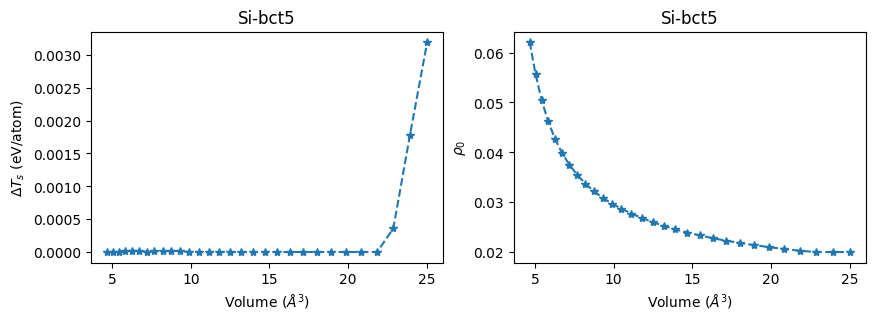

In [30]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(delta_E)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(R0),'*--')
axs[0].set_title('Si-bct5')
axs[1].set_title('Si-bct5')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta T_{s}$ (eV/atom)')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [43]:
delta_E1 = []
R1 = []
vol1 = []
for n in np.arange(27,30,1):
    print('NEW STRUCTURE')
    i = int(n)
    rho = io.read_density('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_bct5/DATA2/rho0'+str(i)+'.xsf')
    ions = Ions.from_ase(ase.io.read('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_bct5/DATA2/Si'+str(i)+'.in'))
    #inputfile = 'bct5.vasp'
    #ions = Ions.from_ase(read(inputfile, format='vasp'))    
    #cell = ions.get_cell()
    #ions.set_cell(cell * l[i], scale_atoms=True) 
    KS_TE = ks_te[i]
    minn = minimize(min_energy, 0.02, args = (KS_TE, rho, ions), method='Powell', bounds=[[0.01,0.03]], options={'ftol' : 1e-5})
    VOLUME = ions.get_volume()
    vol1.append(VOLUME)
    delta_E1.append(minn.fun)
    R1.append(minn.x)

NEW STRUCTURE
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.00143442325939791
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.043972640803259466
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.03931729068551437
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.07831256175902812
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.005960356662751742
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0027623227931359295
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.013943057655016133
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0013369755282282014
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0007537126573700093
setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
0.0002635458907507271
setting key: Si

In [44]:
rho0 = np.asarray(R0)
rho0[27:30] = R1
d_E = np.asarray(delta_E)
d_E[27:30] = delta_E1

Text(0, 0.5, '$ρ_{0}$')

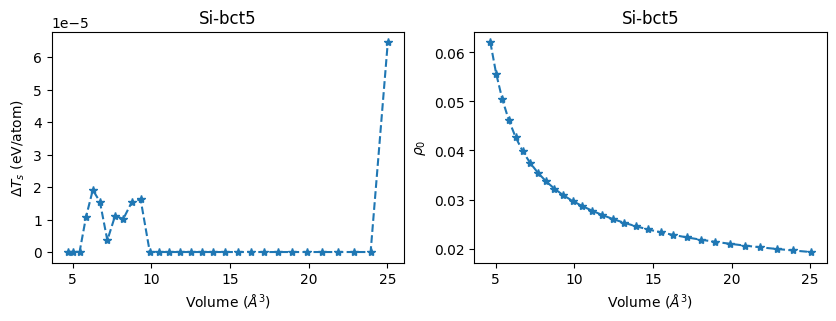

In [45]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(d_E)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(rho0),'*--')
axs[0].set_title('Si-bct5')
axs[1].set_title('Si-bct5')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta T_{s}$ (eV/atom)')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [46]:
np.save("/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_bct5//DATA2/rho0_dTE", R0)

In [48]:
R0

[array([0.06212489]),
 array([0.05569688]),
 array([0.05045739]),
 array([0.04621917]),
 array([0.04275283]),
 array([0.03988542]),
 array([0.03748599]),
 array([0.03547362]),
 array([0.03373332]),
 array([0.03219913]),
 array([0.03087414]),
 array([0.02971492]),
 array([0.02868223]),
 array([0.02772473]),
 array([0.02682569]),
 array([0.02600047]),
 array([0.02524096]),
 array([0.02454379]),
 array([0.02390498]),
 array([0.02331851]),
 array([0.02277809]),
 array([0.02227797]),
 array([0.021815]),
 array([0.02138484]),
 array([0.02098277]),
 array([0.0206048]),
 array([0.02024922]),
 array([0.02]),
 array([0.02]),
 array([0.02])]

In [47]:
np.load("/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_bct5//DATA2/rho0.npy")

array([[0.03585917],
       [0.03508035],
       [0.03444956],
       [0.0337226 ],
       [0.03288663],
       [0.03202594],
       [0.03117853],
       [0.0300161 ],
       [0.02893778],
       [0.02796715],
       [0.0270936 ],
       [0.02631055],
       [0.02560792],
       [0.02495615],
       [0.02432561],
       [0.02376069],
       [0.02326498],
       [0.02282649],
       [0.02244294],
       [0.02210857],
       [0.021818  ],
       [0.02156597],
       [0.02134516],
       [0.02114861],
       [0.02096496],
       [0.02079127],
       [0.02062714],
       [0.02047217],
       [0.02032348],
       [0.02017773]])

In [31]:
R0

[array([0.06212489]),
 array([0.05569688]),
 array([0.05045739]),
 array([0.04621917]),
 array([0.04275283]),
 array([0.03988542]),
 array([0.03748599]),
 array([0.03547362]),
 array([0.03373332]),
 array([0.03219913]),
 array([0.03087414]),
 array([0.02971492]),
 array([0.02868223]),
 array([0.02772473]),
 array([0.02682569]),
 array([0.02600047]),
 array([0.02524096]),
 array([0.02454379]),
 array([0.02390498]),
 array([0.02331851]),
 array([0.02277809]),
 array([0.02227797]),
 array([0.021815]),
 array([0.02138484]),
 array([0.02098277]),
 array([0.0206048]),
 array([0.02024922]),
 array([0.02]),
 array([0.02]),
 array([0.02])]